# Jena Climate Dataset 2010 to 2020

## Dataset preparation

In [1]:
import os
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
tf.debugging.set_log_device_placement(False)

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [3]:
print(tf.config.list_physical_devices()[-1])
print(tf.test.is_built_with_cuda())
print("tensorflow version: " + tf.version.VERSION)
import sys
sys.version

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
True
tensorflow version: 2.8.0


'3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]'

In [4]:
df = pd.read_feather("D:\Datasets\jena_climate\prepared_data_2021_2020.ftr")
df.head()

,Date Time,p (mbar),T (degC),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),Tlog (degC),CO2 (ppm),sin(wd),cos(wd)
0,2010-01-01 00:00:00,967.36,-2.84,-3.43,95.7,4.95,4.74,0.21,3.05,4.90,...,2.96,4.61,0.1,350.0,0.0,0.0,8.66,405.0,0.423883,0.905717
1,2010-01-01 00:10:00,967.56,-2.84,-3.41,95.8,4.95,4.75,0.21,3.06,4.91,...,1.61,2.76,0.0,0.0,0.0,0.0,8.59,404.6,0.265724,0.964049
2,2010-01-01 00:20:00,967.45,-2.85,-3.43,95.7,4.95,4.74,0.21,3.05,4.90,...,2.00,3.10,0.0,0.0,0.0,0.0,8.53,404.1,0.293039,0.956100
3,2010-01-01 00:30:00,967.45,-2.88,-3.46,95.8,4.94,4.73,0.21,3.05,4.89,...,2.25,3.79,0.0,0.0,0.0,0.0,8.52,404.3,0.428147,0.903709
4,2010-01-01 00:40:00,967.34,-2.90,-3.47,95.8,4.93,4.72,0.21,3.04,4.88,...,2.64,3.77,0.0,270.0,0.0,0.0,8.54,404.0,0.400989,0.916083


In [5]:
# converting the dataframe into numpy arrays and separating the temparature column (our target) from the rest (our features)
temperature = df["T (degC)"].to_numpy()
raw_data = df.drop("Date Time", axis=1).to_numpy() # the temperature is included in the raw data! Since we can use past temperature to predict future temps

temperature.shape, raw_data.shape

((578327,), (578327, 20))

In [6]:
train_index = df[pd.to_datetime(df['Date Time']).dt.year ==2019].index[0]
val_index = df[pd.to_datetime(df['Date Time']).dt.year ==2020].index[0]
train_index, val_index

(473070, 525630)

In [7]:
# only the train data gets used to calculate the normalization parameters

mean = raw_data[:train_index].mean(axis=0)
std = raw_data[:train_index].std(axis=0)

mean.shape, std.shape

((20,), (20,))

In [8]:
norm_data = (raw_data-mean)/std

### Train-Validation-Test-Split

In [9]:
train_features = norm_data[:train_index]
train_temp = temperature[:train_index]

val_features = norm_data[train_index:val_index]
val_temp = temperature[train_index:val_index]

test_features = norm_data[val_index:]
test_temp = temperature[val_index:]

train_features.shape, train_temp.shape, val_features.shape, val_temp.shape, test_features.shape, test_temp.shape

((473070, 20), (473070,), (52560, 20), (52560,), (52697, 20), (52697,))

### Instantiate the datasets

using 5 days (720 datapoints) to predict a datapoint 24h (144 datapoints) ahead 

In [10]:
sampling_rate = 1
samples_per_day = int(144/sampling_rate) # 24h * 6 samples per hour

window = 5* samples_per_day
horizon = 1 * samples_per_day
delay = sampling_rate*(window + horizon -1)
batch_size=256

train_ds = tf.keras.utils.timeseries_dataset_from_array(data=train_features[:-horizon],
                                                      targets=train_temp[delay:],
                                                       sequence_length=window,
                                                       sequence_stride=1,
                                                       sampling_rate=sampling_rate,
                                                       batch_size=batch_size,
                                                       shuffle=True)

val_ds = tf.keras.utils.timeseries_dataset_from_array(data=val_features[:-horizon],
                                                      targets=val_temp[delay:],
                                                       sequence_length=window,
                                                       sequence_stride=1,
                                                       sampling_rate=sampling_rate,
                                                       batch_size=batch_size,
                                                       shuffle=True)

test_ds = tf.keras.utils.timeseries_dataset_from_array(data=test_features[:-horizon],
                                                      targets=test_temp[delay:],
                                                       sequence_length=window,
                                                       sequence_stride=1,
                                                       sampling_rate=sampling_rate,
                                                       batch_size=batch_size,
                                                       shuffle=False)

In [11]:
for batch, _ in train_ds:
    print(batch.shape)
    break

(256, 720, 20)


## Models

### Baseline
for a baseline model we predict the temperature now is the same as the temperature now+24h (144 samples)

In [12]:
def evaluate_baseline(dataset):
    
    total_abs_error = 0
    num_of_samples =0 
    for samples, targets in dataset:
        prediction = samples[:, -1, 1]*std[1] + mean[1]
        total_abs_error += np.sum(np.abs(prediction-targets))
        num_of_samples += samples.shape[0]
        
    return total_abs_error/num_of_samples

print(f"Validation MAE: {evaluate_baseline(val_ds):.2f} °C")
print(f"Test MAE: {evaluate_baseline(test_ds):.2f} °C")

Validation MAE: 2.61 °C
Test MAE: 2.66 °C


### A small LSTM


In [13]:
def model_chckpoint(modelname):
    filepath= os.path.join("D:\\ML_models\\JenaClimateModels", modelname)
    return tf.keras.callbacks.ModelCheckpoint(filepath,
                                             monitor ="val_loss",
                                             save_best_only=True)

In [14]:
features = norm_data.shape[-1]

In [15]:
inputs = tf.keras.Input(shape=(window,features))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs, name="model_1")

model.compile(loss="mse",
             optimizer = "adam",
             metrics="mae")

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 20)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                2368      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [17]:
if os.path.exists("D:\\ML_models\\JenaClimateModels\\model_1"):
    m1 = tf.keras.models.load_model("D:\\ML_models\\JenaClimateModels\\model_1")
else:
    h_m1 = model.fit(train_ds,
                epochs =10,
                validation_data = val_ds,
                callbacks=model_chckpoint(model.name))

In [18]:
#history = h_m1.history

NameError: name 'h_m1' is not defined

In [ ]:
#plt.plot(range(0,10), history['mae'], label="train")
#plt.plot(range(0,10), history['val_mae'], label="val")

#plt.legend()

In [19]:
m1 = tf.keras.models.load_model("D:\\ML_models\\JenaClimateModels\\model_1")

In [20]:
prediction = m1.predict(test_ds)

In [21]:
prediction = np.squeeze(prediction)
prediction.shape

(51834,)

In [22]:
test_temp[delay:].shape

(51834,)

Text(0, 0.5, 'Temperature in °C')

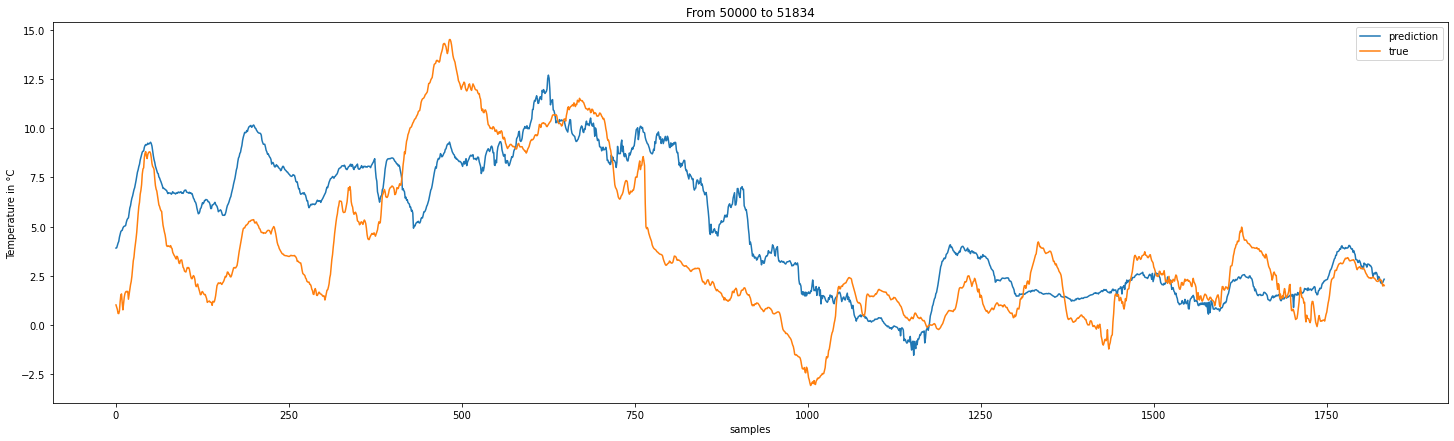

In [23]:
y1 = prediction
y2 = test_temp[delay:]
start=50000
x=range(0,len(y1[start:]))


plt.figure(figsize=(25,7))

plt.plot(x, y1[start:], label="prediction")
plt.plot(x, y2[start:], label="true")
plt.legend()

plt.title(f"From {start} to {len(y1)}")
plt.xlabel("samples")
plt.ylabel("Temperature in °C")

In [24]:
m1.evaluate(test_ds)

203/203 [==============================] - 9s 42ms/step - loss: 9.3101 - mae: 2.3821


[9.310140609741211, 2.382054090499878]

### Stacking LSTM-layers

In [25]:
inputs = tf.keras.Input(shape=(window, features))
x = tf.keras.layers.LSTM(16,return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(16)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs, name="model_2")

model.compile(loss="mse",
             optimizer = "adam",
             metrics="mae")

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 720, 20)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 720, 16)           2368      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_________________________________________________________________


In [26]:
if os.path.exists("D:\\ML_models\\JenaClimateModels\\model_2"):
    m2 = tf.keras.models.load_model("D:\\ML_models\\JenaClimateModels\\model_2")
else:
    h_m2 = model.fit(train_ds,
                epochs =10,
                validation_data = val_ds,
                callbacks=model_chckpoint(model.name))

Epoch 1/10
1845/1845 [==============================] - ETA: 0s - loss: 26.8390 - mae: 3.5982

INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


1845/1845 [==============================] - 267s 143ms/step - loss: 26.8390 - mae: 3.5982 - val_loss: 12.0466 - val_mae: 2.6591
Epoch 2/10
1845/1845 [==============================] - ETA: 0s - loss: 8.7645 - mae: 2.2907

INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


1845/1845 [==============================] - 269s 145ms/step - loss: 8.7645 - mae: 2.2907 - val_loss: 10.2108 - val_mae: 2.4831
Epoch 3/10
1845/1845 [==============================] - ETA: 0s - loss: 7.7171 - mae: 2.1669

INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


INFO:tensorflow:Assets written to: D:\ML_models\JenaClimateModels\model_2\assets


1845/1845 [==============================] - 284s 153ms/step - loss: 7.7171 - mae: 2.1669 - val_loss: 9.6135 - val_mae: 2.4135
Epoch 4/10
1845/1845 [==============================] - 267s 144ms/step - loss: 7.2575 - mae: 2.1036 - val_loss: 10.0810 - val_mae: 2.4866
Epoch 5/10
1845/1845 [==============================] - 259s 141ms/step - loss: 6.9077 - mae: 2.0527 - val_loss: 9.8827 - val_mae: 2.4610
Epoch 6/10
1845/1845 [==============================] - 259s 140ms/step - loss: 6.5930 - mae: 2.0062 - val_loss: 10.5815 - val_mae: 2.5686
Epoch 7/10
1845/1845 [==============================] - 259s 140ms/step - loss: 6.3547 - mae: 1.9697 - val_loss: 10.9238 - val_mae: 2.6184
Epoch 8/10
1845/1845 [==============================] - 260s 141ms/step - loss: 6.1673 - mae: 1.9412 - val_loss: 9.9660 - val_mae: 2.4968
Epoch 9/10
1845/1845 [==============================] - 261s 141ms/step - loss: 6.0549 - mae: 1.9223 - val_loss: 10.4287 - val_mae: 2.5505
Epoch 10/10
1845/1845 [==================

In [28]:
m2.evaluate(test_ds)

203/203 [==============================] - 16s 73ms/step - loss: 9.6340 - mae: 2.4021


[9.63395881652832, 2.4020893573760986]